# CTD Cast vs Mount Temperature Data at Folger Pinnacle (11/07/2023)

- scroll all the way down to see my notes and plots

In [1]:
# set up environment ?
import pandas as pd
import onc
import os
import json
from typing import List, Tuple
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import reduce

#token = os.environ["TRICY_TOKEN"]

from dotenv import load_dotenv
load_dotenv()
token = os.getenv("ONC_TOKEN")

# Create ONC client
my_onc = onc.ONC(token)

In [ ]:
def get_property(start: str, end: str, locationCode: str, deviceCategoryCode: str, sensorCategoryCode: str) -> pd.DataFrame:
    """
    Fetches scalar data using the ONC Python SDK for a given location, device category, sensor property,
    and time window. Returns a merged DataFrame with timestamps and sensor values.

    Parameters:
        start (str): Start date in ISO 8601 format (e.g., "2023-07-11T17:00:00.000Z").
        end (str): End date in ISO 8601 format (e.g., "2023-07-11T22:30:00.000Z").
        locationCode (str): ONC location code (e.g., "CF341").
        deviceCategoryCode (str): ONC device category (e.g., "CTD").
        sensorCategoryCode (str): Comma-separated sensor types to fetch (e.g., "depth,temperature").

    Returns:
        pd.DataFrame: DataFrame containing merged sensor values with a timestamp index.
    """
    params = {
        "locationCode": locationCode,
        "deviceCategoryCode": deviceCategoryCode,
        "sensorCategoryCodes": sensorCategoryCode,
        "dateFrom": start,
        "dateTo" : end
    }

    # JSON response from ONC
    result = my_onc.getScalardata(params)

    # error handle if there is no data returned
    if not result or "sensorData" not in result or result["sensorData"] is None or len(result["sensorData"]) == 0:
        print(f"No data returned for devices in {deviceCategoryCode} at {locationCode} between {start} and {end}.")
        return
        
    else:
        # extract the relevant sensors from the JSON response

        dfs = []

        for sensor in result["sensorData"]:
            # extract each sensors data fields
            prop = sensor["sensorCategoryCode"]
            times = sensor["data"]["sampleTimes"]
            values = sensor["data"]["values"]
            unit = sensor["unitOfMeasure"]

            # populate dataframe (Pandas)
            df = pd.DataFrame({
                # syntax: "label": variable
                "timestamp": pd.to_datetime(times), # convert strings to datetime objects
                prop: values,
                "uom": unit
            })
            dfs.append(df)

    # merge dataframes by joining on timestamp    
    df_merged = reduce(lambda left, right: pd.merge(left, right, on="timestamp", how="outer"), dfs)
    df_merged.sort_values("timestamp", inplace=True)
    
    #df_merged.head()
    return df_merged

In [ ]:
def detect_cast_intervals(df: pd.DataFrame, gap_threshold_minutes: int = 10) -> List[Tuple[str, str]]:
    """
    Detects individual CTD cast intervals based on time gaps in the data.

    Parameters:
        df (pd.DataFrame): DataFrame with a 'timestamp' column (datetime format).
        gap_threshold_minutes (int): Time gap threshold to detect breaks between casts.

    Returns:
        List[Tuple[str, str]]: List of (dateFrom, dateTo) pairs in ISO 8601 UTC format.
    """
    # error handle 
    if df.empty or "timestamp" not in df.columns:
        return []

    # Sort and reset index (index is timestamp)
    df = df.sort_values("timestamp").reset_index(drop=True)

    # Calculate time gaps between consecutive timestamps
    gaps = df["timestamp"].diff().fillna(pd.Timedelta(seconds=0))
    new_cast_starts = df.index[gaps > pd.Timedelta(minutes=gap_threshold_minutes)].tolist()

    # Start of first cast is always 0
    cast_starts = [0] + new_cast_starts
    cast_ends = new_cast_starts + [len(df)]

    # Format intervals as ISO 8601 with milliseconds and Z (UTC)
    intervals = []
    for start_idx, end_idx in zip(cast_starts, cast_ends):
        start = df["timestamp"].iloc[start_idx].strftime("%Y-%m-%dT%H:%M:%S.000Z")
        end = df["timestamp"].iloc[end_idx - 1].strftime("%Y-%m-%dT%H:%M:%S.000Z")
        intervals.append((start,end))

    return intervals


In [ ]:
def detect_deep_intervals(df: pd.DataFrame, depth_threshold: int, gap_threshold_seconds: int = 60) -> List[Tuple[str, str]]:
    """
    Detects continuous time intervals where depth exceeds a threshold.
    
    Parameters:
        df (pd.DataFrame): DataFrame with 'timestamp' and 'depth' columns.
        depth_threshold (float): Minimum depth to include.
        gap_threshold_seconds (int): Max allowed time gap between points within an interval.
    
    Returns:
        List[Tuple[str, str]]: List of (start, end) timestamp strings in ISO 8601 UTC format.
    """
    # create copy of df, filtering for deep sections
    df_deep = df[df["depth"] > depth_threshold].copy()

    # error handle
    if df_deep.empty:
        return []

    # eSort and reset index (index is timestamp)
    df_deep = df_deep.sort_values("timestamp").reset_index(drop=True)

    # Calculate time gaps between 1 or more deep sections
    df_deep["delta"] = df_deep["timestamp"].diff().dt.total_seconds()

    intervals = []
    start_time = df_deep.loc[0, "timestamp"]

    for i in range(1, len(df_deep)):
        if df_deep.loc[i, "delta"] > gap_threshold_seconds:
            end_time = df_deep.loc[i - 1, "timestamp"]
            intervals.append((
                start_time.strftime("%Y-%m-%dT%H:%M:%S.000Z"),
                end_time.strftime("%Y-%m-%dT%H:%M:%S.000Z")
            ))
            start_time = df_deep.loc[i, "timestamp"]

    # Add final interval
    intervals.append((
        start_time.strftime("%Y-%m-%dT%H:%M:%S.000Z"),
        df_deep.iloc[-1]["timestamp"].strftime("%Y-%m-%dT%H:%M:%S.000Z")
    ))

    return intervals


In [5]:
def plot_cast(start: pd.Timedelta, end: pd.Timedelta, locationCode: str, deviceCategoryCode: str,
                  sensorCategoryCode: str, df: pd.DataFrame, depth_theshold: int) -> None:
    """
    Plots a sensor property time-series with optional cast interval markers.

    Parameters:
        start (pd.Timedelta): Start time in ISO 8601 format.
        end (pd.Timedelta): End time in ISO 8601 format.
        locationCode (str): ONC location code.
        deviceCategoryCode (str): ONC device category.
        sensorCategoryCode (str): Sensor property (e.g., "depth").
        df (pd.DataFrame): DataFrame containing 'timestamp' and property column.
        depth_theshold (int): Minimum depth to include.
    
    Returns:
        None
    """
    start_dt = pd.to_datetime(start)
    end_dt = pd.to_datetime(end)
    
    df_int = df[
        (df["timestamp"] >= start_dt) &
        (df["timestamp"] <= end_dt) &
        (df["depth"] >= depth_theshold)
    ]

    if df_int.empty:
        print(f"Skipping empty cast interval: {start} to {end}")
        return

    ax = df_int.plot(
        x="temperature",
        y="depth",
        xlabel="Temperature (°C)",
        ylabel="Depth (m)",
        title=f"CTD Cast at {locationCode}\n{start_dt.strftime('%H:%M:%S')} to {end_dt.strftime('%H:%M:%S')} UTC"
    )

    ax.invert_yaxis() # let depth increase downwards along the y-axis

In [6]:
def plot_mount(start: pd.Timedelta, end: pd.Timedelta, locationCode: str, deviceCategoryCode: str,
                  sensorCategoryCode: str, df: pd.DataFrame) -> None:
    """
    Plots a sensor property time-series with optional cast interval markers.

    Parameters:
        start (pd.Timedelta): Start time in ISO 8601 format.
        end (pd.Timedelta): End time in ISO 8601 format.
        locationCode (str): ONC location code.
        deviceCategoryCode (str): ONC device category.
        sensorCategoryCode (str): Sensor property (e.g., "depth").
        df (pd.DataFrame): DataFrame containing 'timestamp' and property column.
    
    Returns:
        None
    """
    # convert start and end strings to datetime objects
    start_dt = pd.to_datetime(start)
    end_dt = pd.to_datetime(end)

    df_int = df[(df["timestamp"] >= start) & (df["timestamp"] <= end)] # filter the df to get the relevant cast interval
    
    df_int.plot(x = "timestamp", 
                y = "temperature", 
                xlabel = "Time (HH:MM:SS)", 
                ylabel = "Temperature (C)", 
                title = f"CTD Mount at {locationCode}\n {start_dt.strftime('%H:%M:%S')} to {end_dt.strftime('%H:%M:%S')} UTC" # plot and label
    )

### CTD Cast vs Mount Temperature Data at Fogler Pinnacle

Notes:
 - I estimated Pinnacle depth as 23m and have filtered cast data for when the cast is at least 20m deep
- Other than displaying data from the exact time frame of the cast, and filtering for the sub section where the cast is at least 20m deep, I have applied to no real processing
- I have not yet put the mount and cast data on the same plot, but that will be a goal for tomorrow

Possible Issues:
- Closeness of depth needed to compare casts/mounts and extremely small time series 

### Date of Interest: July 11, 2023

In [7]:
# date of interest: July 11, 2023
# note: I narrowed down the time slot using the plotting utility on Oceans 3.0
dateFrom = "2023-07-11T17:00:00.000Z"
dateTo = "2023-07-11T22:30:00.000Z"

# fetch data for CTD casts and mounts from July 11, 2023
cast_df = get_property(dateFrom, dateTo, "CF341", "CTD", "depth,temperature") # populate dataframe of entire day
mount_df = get_property(dateFrom, dateTo, "FGPPN", "CTD", "temperature")


### Detect cast time intervals and isolate respective cast and mount data

In [8]:
# isolate cast time intervals, and deep section of each cast
cast_ints = detect_cast_intervals(cast_df, 10) # isolate time intervals for each cast
deep_ints = detect_deep_intervals(cast_df, 20, 60) # isolate time intervals for deep section (>= 20m)of each cast

# isolate cast 1 and 2 deep sections
cast_start1,cast_end1 = deep_ints[0]
cast_start2,cast_end2 = deep_ints[1]

# print intervals to console
print("Cast intervals (UTC):")
for cast_start, cast_end in cast_ints:
   print(f"Start: {cast_start}, End: {cast_end}")

print()

print("Deep section of cast intervals (UTC):")
for cast_start, cast_end in deep_ints:
   print(f"Start: {cast_start}, End: {cast_end}")

Cast intervals (UTC):
Start: 2023-07-11T17:12:51.000Z, End: 2023-07-11T17:14:20.000Z
Start: 2023-07-11T20:13:27.000Z, End: 2023-07-11T20:15:39.000Z

Deep section of cast intervals (UTC):
Start: 2023-07-11T17:13:58.000Z, End: 2023-07-11T17:14:20.000Z
Start: 2023-07-11T20:15:03.000Z, End: 2023-07-11T20:15:39.000Z


### Plot cast 1 and mount temperature data

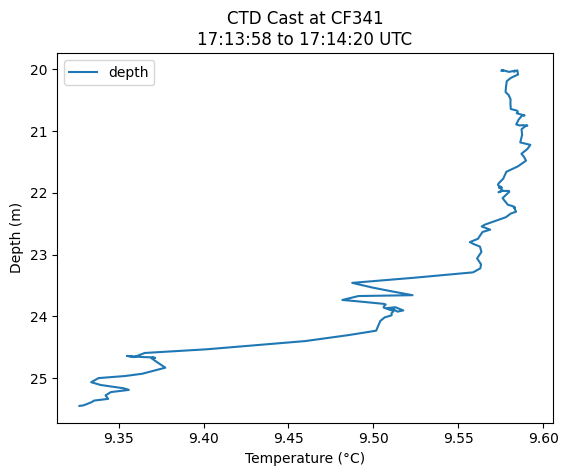

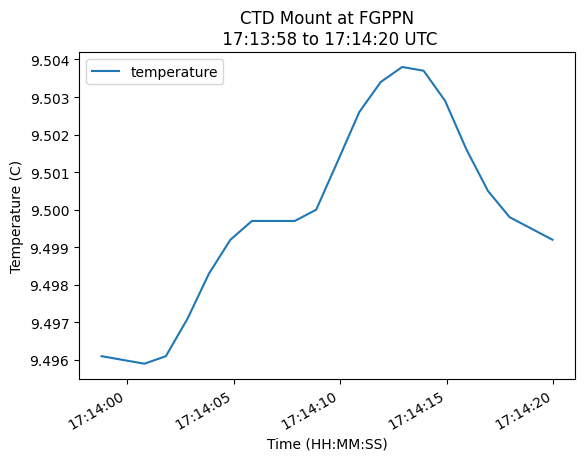

In [9]:
# Plot cast 1 and mount temperature data
plot_cast(cast_start1, cast_end1, "CF341", "CTD", "depth", cast_df, 20) # plot depth and temperature profile for each cast
plot_mount(cast_start1, cast_end1, "FGPPN", "CTD", "depth", mount_df) # plot temperature and time profile for each mount

### Plot cast 2 and mount temperature data

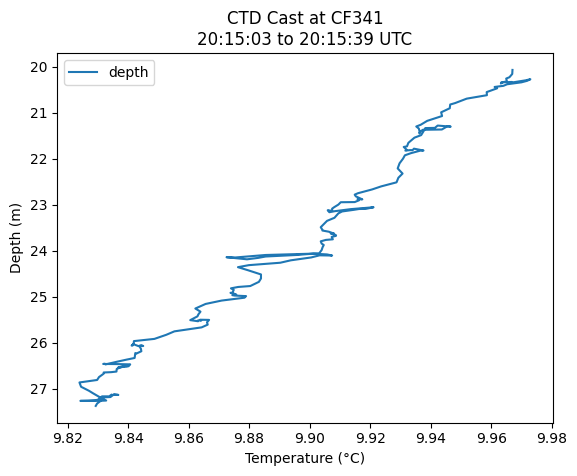

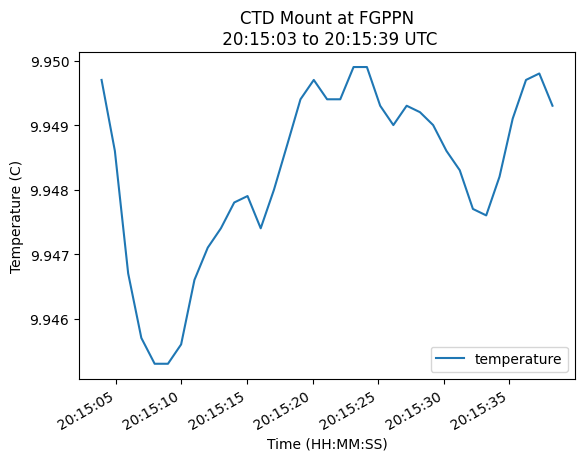

In [10]:
# Plot cast 2 and mount temperature data
plot_cast(cast_start2, cast_end2, "CF341", "CTD", "depth", cast_df, 20) # plot depth and temperature profile for each cast
plot_mount(cast_start2, cast_end2, "FGPPN", "CTD", "depth", mount_df) # plot temperature and time profile for each mount

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1cd2cd01-70e8-41b6-af2d-f797c6675dbe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>